In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import xarray as xr
import pandas as pd
import csv

In /Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


# What this notebook does:
- Defines single and multi-layer neural network classes
    - Both have learning rate and momentum variables (between 0 and 1 is required)
    - Both have 2 options for activation function (sigmoid or swish)
    - Multi-layer allows for specifying number of hidden nodes
- Shows several examples of each type of NN with idealized data
- Shows several examples of each type of NN with real data

This notebook was built following the tutorials from:
- https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
- https://medium.com/towards-artificial-intelligence/building-neural-networks-from-scratch-with-python-code-and-math-in-detail-i-536fae5d7bbf
- https://medium.com/towards-artificial-intelligence/building-neural-networks-with-python-code-and-math-in-detail-ii-bbe8accbf3d1
- https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx
- https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/

I took my favorite parts from each one and combined them into something I feel is more useable, understandable, and clean.

# Single layer NN

In [2]:
# create NeuralNetwork class
class SL_NeuralNetwork:

    # intialize variables in class
    def __init__(self, inputs, outputs, weights=None, 
                 activation_fn='sigmoid',
                 lr=0.05, momentum=0.5):
        if activation_fn == 'swish':
            self.actfn = self.swish
        else:
            self.actfn = self.sigmoid
        self.inputs   = inputs
        self.outputs  = outputs
        self.lr       = lr
        self.momentum = momentum
        
        if weights == None:
            weight_len = np.shape(inputs[1])[0]
            self.weights = np.random.rand(weight_len).reshape((weight_len,1))
        else:
            self.weights = weights
            
        self.error_history = []
        self.epoch_list = []
        self.weight_increment = 0.0
        
    def sigmoid(self, x, deriv=False):
        if deriv == True:
            return 1/(1+np.exp(-x)) * (1 - 1/(1+np.exp(-x)))
        return 1 / (1 + np.exp(-x))

    def swish(self, x, deriv=False):
        if deriv == True:
            return ((np.exp(-x)*(x+1)) + 1.0)/((1.0+np.exp(-x))**2)
        return (x / (1 + np.exp(-x)))
    
    # data will flow through the neural network.
    def feed_forward(self):
        self.hidden = self.actfn(np.dot(self.inputs, self.weights))

    # going backwards through the network to update weights
    def backpropagation(self):
        self.error  = self.outputs - self.hidden
        delta = self.error * self.actfn(self.hidden, deriv=True)
        self.weight_increment = self.lr * np.dot(self.inputs.T, delta) + self.momentum*self.prev_weight_inc
        self.prev_weight_inc = self.weight_increment.copy()
        self.weights += self.weight_increment
        
    def train(self, epochs=50000):
        self.prev_weight_inc = np.zeros(self.weights.shape)
        for epoch in range(epochs):
            # flow forward and produce an output
            self.feed_forward()
            # go back though the network to make corrections based on the output
            self.backpropagation()    
            # keep track of the error history over each epoch
            self.error_history.append(np.average(np.abs(self.error)))
            self.epoch_list.append(epoch)

    # function to predict output on new and unseen input data                               
    def predict(self, new_input):
        prediction = self.actfn(np.dot(new_input, self.weights))
        return prediction

# Multi-layer NN

In [3]:
# create NeuralNetwork class
class ML_NeuralNetwork:

    # intialize variables in class
    def __init__(self, inputs, outputs, 
                 weights_hid=None, 
                 weights_out=None,
                 activation_fn='sigmoid',
                 lr=0.05, momentum=0.5,
                 hidden_nodes=5):
        
        if activation_fn == 'swish':
            self.actfn = self.swish
        else:
            self.actfn = self.sigmoid
        self.inputs   = inputs
        self.outputs  = outputs
        self.lr       = lr
        self.momentum = momentum
        
        if weights_hid is None:
            weight_len = np.shape(inputs)[1]
            self.weights_hid = np.random.rand(weight_len,hidden_nodes)
        else:
            self.weights_hid = weights_hid
        if weights_out is None:
            self.weights_out = np.random.rand(hidden_nodes,1)
        else:
            self.weights_out = weights_out
            
        self.error_history = []
        self.epoch_list = []
        self.weight_increment = 0.0
        
    #activation function ==> S(x) = 1/1+e^(-x)
    def sigmoid(self, x, deriv=False):
        if deriv == True:
            return 1/(1+np.exp(-x)) * (1 - 1/(1+np.exp(-x)))
        return 1 / (1 + np.exp(-x))

    def swish(self, x, deriv=False):
        if deriv == True:
            return ((np.exp(-x)*(x+1)) + 1.0)/((1.0+np.exp(-x))**2)
        return (x / (1 + np.exp(-x)))
    
    # data will flow through the neural network.
    def feed_forward(self):
        self.input_hid = np.dot(self.inputs, self.weights_hid) # input_hidden
        self.output_hid = self.actfn(self.input_hid) # output_hidden
        
        self.input_out = np.dot(self.output_hid, self.weights_out) # input_op
        self.ouput_out = self.actfn(self.input_out) # output_op
        
    # going backwards through the network to update weights
    def backpropagation(self):     
        self.error_out = (0.5*(np.power((self.ouput_out - self.outputs), 2)))
        
        # Phase 1: Output weights
        delta_out = (self.ouput_out - self.outputs) * self.actfn(self.input_out, deriv=True)
        weight_increment_out = output_hiddenerror_dwo = np.dot(self.output_hid.T, delta_out)

        # Phase 2: hidden weights
        delta_hid = self.actfn(self.input_hid, deriv=True) * np.dot(delta_out , self.weights_out.T)
        weight_increment_hid = np.dot(self.inputs.T, delta_hid)

        self.weight_increment_out = weight_increment_out
        self.weight_increment_hid = weight_increment_hid
        
        self.weights_out -= (lr * self.weight_increment_out) + self.momentum*self.prev_weight_inc_out
        self.weights_hid -= (lr * self.weight_increment_hid) + self.momentum*self.prev_weight_inc_hid
        
        self.prev_weight_inc_out = self.weight_increment_out.copy()
        self.prev_weight_inc_hid = self.weight_increment_hid.copy()
        
    def train(self, epochs=50000):
        self.prev_weight_inc_hid = np.zeros(self.weights_hid.shape)
        self.prev_weight_inc_out = np.zeros(self.weights_out.shape)
        for epoch in range(epochs):
            # flow forward and produce an output
            self.feed_forward()
            
            # go back though the network to make corrections based on the output
            self.backpropagation()    
            # keep track of the error history over each epoch
            self.error_history.append(np.average(np.abs(self.error_out)))
            self.epoch_list.append(epoch)

    # function to predict output on new and unseen input data                               
    def predict(self, new_input):
        prediction = self.actfn(np.dot(self.actfn(np.dot(new_input,self.weights_hid)),self.weights_out))
        return prediction

# Idealized data:

### Logical "OR" Single Layer:

SL: 0.065; SL-swish: -0.248; ML: 0.002; ML-swish: -0.000; target: 0.000
SL: 0.906; SL-swish: 0.453; ML: 0.907; ML-swish: 1.033; target: 1.000
SL: 0.996; SL-swish: 1.422; ML: 0.956; ML-swish: 0.994; target: 1.000


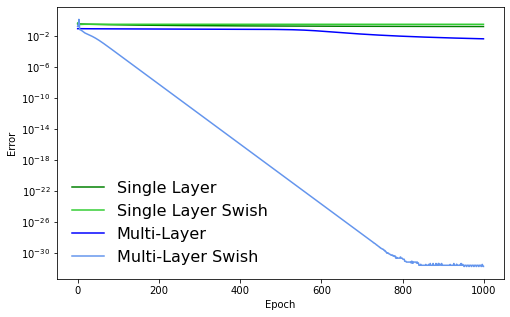

In [4]:
# This will produce the same as a logical or operator

test_in = np.array([[0,0],[0,1],[1,0],[1,1]])
target  = np.array([[0,1,1,1]]).reshape(4,1)

# Learning Rate (lr) is VERY important... needs to be small so that model does not get stuck in local minimum!
# ... if you're not seeing convergent errors, odds are the LR is too large
lr = 0.03

# Momentum also helps to reduce the chance of getting caught in a loc. min by adding some percentage (momentum)
# ... of the previous weight change to the new one.
momentum = 0.5

n_epochs = 1000

SLNN_or = SL_NeuralNetwork(test_in,target,lr=lr,momentum=momentum)
SLNN_or.train(n_epochs)
SLNN_orSwish = SL_NeuralNetwork(test_in,target,lr=lr,momentum=momentum,activation_fn='swish')
SLNN_orSwish.train(n_epochs)
MLNN_or = ML_NeuralNetwork(test_in,target,lr=lr,momentum=momentum,hidden_nodes=3)
MLNN_or.train(n_epochs)
MLNN_orSwish = ML_NeuralNetwork(test_in,target,lr=lr,momentum=momentum,hidden_nodes=3,activation_fn='swish')
MLNN_orSwish.train(n_epochs)

o1 = np.array([0,-1])
o2 = np.array([0,0.85])
o3 = np.array([1,1.1])

to1,to2,to3 = [0,1,1]

test_out = [o1,o2,o3]
target_out_test = [to1,to2,to3]
for tout,targ in zip(test_out,target_out_test):
    predicted_out_SL  = float(SLNN_or.predict(tout))
    predicted_out_SLS = float(SLNN_orSwish.predict(tout))
    predicted_out_ML  = float(MLNN_or.predict(tout))
    predicted_out_MLS = float(MLNN_orSwish.predict(tout))
    print('SL: {0:4.3f}; SL-swish: {3:4.3f}; ML: {1:4.3f}; ML-swish: {4:4.3f}; target: {2:4.3f}'.format(
        predicted_out_SL,predicted_out_ML,targ,predicted_out_SLS,predicted_out_MLS))
    
# plot the error over the entire training duration
plt.figure(figsize=(8,5))
plt.semilogy(SLNN_or.epoch_list, SLNN_or.error_history,c='g',label='Single Layer')
plt.semilogy(SLNN_orSwish.epoch_list, SLNN_orSwish.error_history,c='limegreen',label='Single Layer Swish')
plt.semilogy(MLNN_or.epoch_list, MLNN_or.error_history,c='b',label='Multi-Layer')
plt.semilogy(MLNN_orSwish.epoch_list, MLNN_orSwish.error_history,c='cornflowerblue',label='Multi-Layer Swish')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(frameon=False,fontsize=16)
plt.show()

#### --- Single layer performs well and trains faster

### Non-linearly separable data:

SL: 0.500; SL-swish: -0.168; ML: 0.000; ML-swish: -0.013; target: 0.000
SL: 0.500; SL-swish: 1.901; ML: 0.984; ML-swish: -0.000; target: 1.000
SL: 0.500; SL-swish: 0.672; ML: 0.009; ML-swish: -0.000; target: 0.000


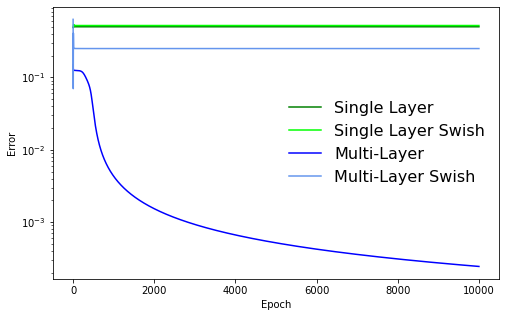

In [5]:
# Now the expectation is separated into 2 regions in which we expect 0 (0,0) and (1,1):

test_in = np.array([[0,0],[0,1],[1,0],[1,1]])
target  = np.array([[0,1,1,0]]).reshape(4,1)

lr = 0.05

# Needed a higher momentum for stability...
momentum = 0.9

n_epochs = 10000

SLNN_nl = SL_NeuralNetwork(test_in,target,lr=lr,momentum=momentum)
SLNN_nl.train(n_epochs)
MLNN_nl = ML_NeuralNetwork(test_in,target,lr=lr,momentum=momentum,hidden_nodes=3)
MLNN_nl.train(n_epochs)

SLNN_nl_swish = SL_NeuralNetwork(test_in,target,lr=lr,momentum=momentum,activation_fn='swish')
SLNN_nl_swish.train(n_epochs)
MLNN_nl_swish = ML_NeuralNetwork(test_in,target,lr=lr,momentum=momentum,hidden_nodes=3,activation_fn='swish')
MLNN_nl_swish.train(n_epochs)


o1 = np.array([0,-1])
o2 = np.array([0,5])
o3 = np.array([1,1.2])

to1,to2,to3 = [0,1,0]

test_out = [o1,o2,o3]
target_out_test = [to1,to2,to3]
for tout,targ in zip(test_out,target_out_test):
    predicted_out_SL  = float(SLNN_nl.predict(tout))
    predicted_out_ML  = float(MLNN_nl.predict(tout))
    predicted_out_SLs = float(SLNN_nl_swish.predict(tout))
    predicted_out_MLs = float(MLNN_nl_swish.predict(tout))
    print('SL: {0:4.3f}; SL-swish: {3:4.3f}; ML: {1:4.3f}; ML-swish: {4:4.3f}; target: {2:4.3f}'.format(
        predicted_out_SL,predicted_out_ML,targ,predicted_out_SLs,predicted_out_MLs))
    
# plot the error over the entire training duration
plt.figure(figsize=(8,5))
plt.semilogy(SLNN_nl.epoch_list, SLNN_nl.error_history,c='g',label='Single Layer')
plt.semilogy(SLNN_nl_swish.epoch_list, SLNN_nl_swish.error_history,c='lime',label='Single Layer Swish')
plt.semilogy(MLNN_nl.epoch_list, MLNN_nl.error_history,c='b',label='Multi-Layer')
plt.semilogy(MLNN_nl_swish.epoch_list, MLNN_nl_swish.error_history,c='cornflowerblue',label='Multi-Layer Swish')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(frameon=False,fontsize=16)
plt.show()

#### --- Single layer performs very poorly but multi-layer does really well. The swish function is very bad here

### Random data...

SL: 0.792; SL-swish: 0.894; ML: 0.792; ML-swish: 0.894; target: 0.921
SL: 0.332; SL-swish: 0.159; ML: 0.332; ML-swish: 0.159; target: 0.141


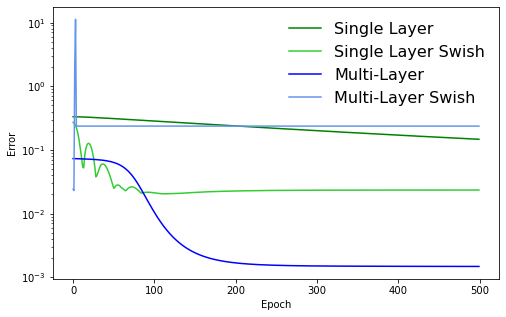

In [6]:
# This one is kind of dumb, but let's see what it does... the expectation is the middle column

inputs = np.array([[0, 0, 1],
                   [0, 0.4, 1],
                   [0, 0.2, 1],
                   [0, 1, 1],
                   [0, 0.8, 1],
                   [0, 1, 1]])
# output data
outputs = np.array([[0.0], [0.4], [0.2], [1.0], [0.8], [1.0]])

# Swish function is pretty unstable here... needed lower lr and higher momentum:
lr = 0.005
momentum = 0.9

n_epochs = 500

# create neural networks  
SLNN_test = SL_NeuralNetwork(inputs, outputs, lr=lr, momentum=momentum)
SLNN_test.train(epochs=n_epochs)
SLNN_test_swish = SL_NeuralNetwork(inputs, outputs, lr=lr, momentum=momentum, activation_fn='swish')
SLNN_test_swish.train(epochs=n_epochs)
MLNN_test = ML_NeuralNetwork(inputs, outputs, lr=lr, momentum=momentum, hidden_nodes=3)
MLNN_test.train(epochs=n_epochs)
MLNN_test_swish = ML_NeuralNetwork(inputs, outputs, lr=lr, momentum=momentum, activation_fn='swish', hidden_nodes=3)
MLNN_test_swish.train(epochs=n_epochs)

# create two new examples to predict                                   
example = np.array([[0, 0.9, 1]])
example_2 = np.array([[0, 0.16, 1]])

test_out = [example,example_2]
target_out_test = [example[0][1],example_2[0][1]]
for tout,targ in zip(test_out,target_out_test):
    predicted_out_SL = float(SLNN_test.predict(tout))
    predicted_out_ML = float(MLNN_test.predict(tout))
    predicted_out_SLs = float(SLNN_test_swish.predict(tout))
    predicted_out_MLs = float(MLNN_test_swish.predict(tout))
    print('SL: {0:4.3f}; SL-swish: {1:4.3f}; ML: {0:4.3f}; ML-swish: {1:4.3f}; target: {2:4.3f}'.format(
        predicted_out_SL,predicted_out_SLs,predicted_out_ML,predicted_out_MLs,targ))

# plot the error over the entire training duration
plt.figure(figsize=(8,5))
plt.semilogy(SLNN_test.epoch_list, SLNN_test.error_history,c='g',label='Single Layer')
plt.semilogy(SLNN_test_swish.epoch_list, SLNN_test_swish.error_history,c='limegreen',label='Single Layer Swish')
plt.semilogy(MLNN_test.epoch_list, MLNN_test.error_history,c='b',label='Multi-Layer')
plt.semilogy(MLNN_test_swish.epoch_list, MLNN_test_swish.error_history,c='cornflowerblue',label='Multi-Layer Swish')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(frameon=False,fontsize=16)
plt.show()

# For real data (non-binary) we need to...
### 1. scale between 0 and 1
### 2. split data into training and testing
### 3. stack the inputs into 1 matrix

In [7]:
def normalize_inputs(inputs):
    ndims = np.shape(inputs)[1]
    shift = np.zeros(ndims)
    scale = np.zeros(ndims)
    norm_in = np.zeros(np.shape(inputs))
    for dim in np.arange(0,ndims):
        shift[dim] = np.nanmin(inputs[:,dim])
        norm_in[:,dim] = inputs[:,dim] - shift[dim]
        scale[dim] = np.nanmax(norm_in[:,dim])
        norm_in[:,dim] /= scale[dim]
    return norm_in,shift,scale
    

def split_data(varns,train_ind,vars_to_consider=None):
    if vars_to_consider is None:
        vars_to_consider = list(varns.keys())
        
    train_vars = [[]]*len(vars_to_consider)
    test_vars  = [[]]*len(vars_to_consider)
    for vv,varn in enumerate(vars_to_consider):
        train_vars[vv] = varns[varn][:train_ind]
        test_vars[vv]  = varns[varn][train_ind:]
        
    return train_vars,test_vars

def stack_inputs(inputs,shift,scale):
    n_inputs = len(shift)
    norm_inputs = []
    for ni in range(0,n_inputs):
        norm_inputs.append((inputs[ni] - shift[ni])/scale[ni])
    return np.stack(tuple(norm_inputs)).T

# Using meteorological tower data:

## Download the testMetData.csv before continuing:

In [8]:
# - - - - - - - USER SETTINGS  -- - - - - - #
# How much of the data do you want to use for training?
train_pct = 0.8 # The remainder (1-train_pct) goes towards testing

# Which variable do you want to predict?
target_varn = 'U' # Options are u, v, T, RH, P, U

# Do you want to use the target_varn in the training? (Probably shouldn't)
drop_target_varn = True 

# - - - - - - END USER SETTINGS - - - - - - #

data = pd.read_csv('~/Code/Python/demo/testMetData.csv',index_col=0,header=0,parse_dates=True)
varn_dict = {'u':data.u.values,
             'v':data.v.values,
             'T':data['T'].values,
            'RH':data.RH.values,
             'P':data.P.values,
             'U':data.U.values,
            }
time_f = data.index.values



train_ind = int(train_pct*len(varn_dict['u']))

target_out = varn_dict[target_varn]

vars_to_consider = list(varn_dict.keys())

if drop_target_varn:
    vars_to_consider.remove(target_varn)
train_vars, test_vars = split_data(varn_dict,train_ind,vars_to_consider)

0.7685227795674182 0.9912563276576162
0.6356856634016029 0.8496215494211933
0.5699860183315208 0.9147118222774585
0.06702094404501409 0.21510888819422735
0.13353863381858205 0.4423292273236075


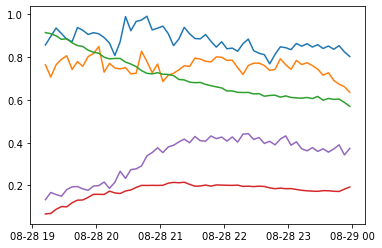

In [9]:
inputs = np.stack(train_vars).T
#outputs = (u + np.random.rand(len(u))).reshape((len(vel),1))
outputs = target_out[:train_ind].reshape((len(train_vars[0]),1))

norm_in,shift,scale = normalize_inputs(inputs)
norm_out,shift_out,scale_out = normalize_inputs(outputs)
#norm_in = (inputs)/scale_out

test_inputs = stack_inputs(test_vars,shift=shift,scale=scale)

# Notice the inputs are now between 0 and 1
for ti in test_inputs.T:
    print(np.nanmin(ti),np.nanmax(ti))
    plt.plot(time_f[train_ind:],ti)
plt.show()

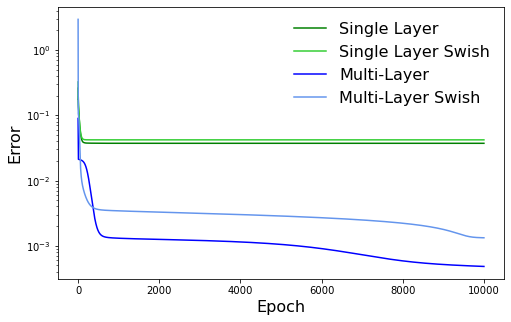

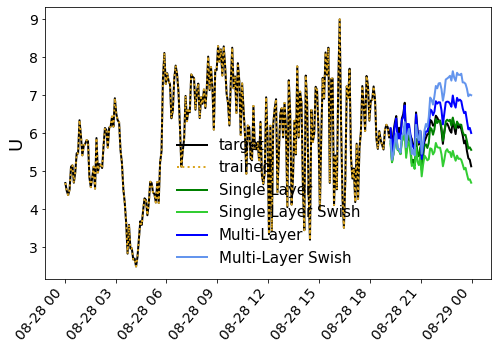

In [10]:
lr = 0.02
momentum = 0.7

hidden_nodes = 5

n_epochs = 10000

# create neural networks
# Note that those using 'swish' needed adjusting in lr and momentum for stability
SL_NN = SL_NeuralNetwork(norm_in, norm_out, activation_fn='sigmoid',
                      lr=lr, momentum=momentum)
SL_NN.train(epochs=n_epochs)

SL_NN_swish = SL_NeuralNetwork(norm_in, norm_out, activation_fn='swish',
                      lr=0.003, momentum=0.5)
SL_NN_swish.train(epochs=n_epochs)

ML_NN =  ML_NeuralNetwork(norm_in, norm_out, hidden_nodes=hidden_nodes,
                           activation_fn='sigmoid',
                           lr=lr, momentum=0.0)
ML_NN.train(epochs=n_epochs)

ML_NN_swish =  ML_NeuralNetwork(norm_in, norm_out, hidden_nodes=hidden_nodes,
                           activation_fn='swish',
                           lr=0.003, momentum=0.0)
ML_NN_swish.train(epochs=n_epochs)

# print the predictions for both examples
#count = 0
predicted_out_sl = np.zeros(np.shape(test_vars[0]))
predicted_out_ml = np.zeros(np.shape(test_vars[0]))
predicted_out_sls = np.zeros(np.shape(test_vars[0]))
predicted_out_mls = np.zeros(np.shape(test_vars[0]))
for tt,ti in enumerate(test_inputs):
    real_u = ti[0]*scale[0] + shift[0]
    real_v = ti[1]*scale[1] + shift[1]
    real_vel = (real_u**2 + real_v**2)**0.5
    #print(ti[0]*scale_out + shift_out, real_u)
    #print(ti)
    predicted_out_sl[tt]  = SL_NN.predict(ti)*scale_out + shift_out
    predicted_out_ml[tt]  = ML_NN.predict(ti)*scale_out + shift_out
    predicted_out_sls[tt] = SL_NN_swish.predict(ti)*scale_out + shift_out
    predicted_out_mls[tt] = ML_NN_swish.predict(ti)*scale_out + shift_out
    #print(NN.predict(ti)*scale_out + shift_out , ' - Correct: ', real_u*2.0 )
    #count+=1

# plot the error over the entire training duration
plt.figure(figsize=(8,5))
plt.semilogy(SL_NN.epoch_list, SL_NN.error_history,c='g', label='Single Layer')
plt.semilogy(SL_NN_swish.epoch_list, SL_NN_swish.error_history,c='limegreen', label='Single Layer Swish')
plt.semilogy(ML_NN.epoch_list, ML_NN.error_history,c='b', label='Multi-Layer')
plt.semilogy(ML_NN_swish.epoch_list, ML_NN_swish.error_history,c='cornflowerblue', label='Multi-Layer Swish')
plt.xlabel('Epoch',size=16)
plt.ylabel('Error',size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(time_f,target_out,c='k',lw=2.0,label='target')
plt.plot(time_f[:train_ind],target_out[:train_ind],c='goldenrod',ls=':',lw=2.0,label='trained')

plt.plot(time_f[train_ind:],predicted_out_sl,c='g',lw=2.0,label='Single Layer')
plt.plot(time_f[train_ind:],predicted_out_sls,c='limegreen',lw=2.0,label='Single Layer Swish')
plt.plot(time_f[train_ind:],predicted_out_ml,c='b',lw=2.0,label='Multi-Layer')
plt.plot(time_f[train_ind:],predicted_out_mls,c='cornflowerblue',lw=2.0,label='Multi-Layer Swish')
plt.tick_params(labelsize=14)
plt.xticks(rotation=50.0,ha='right')
plt.legend(frameon=False,fontsize=15)
plt.ylabel(target_varn,size=18)
plt.show()

### Inspecting the weights can be insightful:

In [11]:
print('variable\tweight')
for varn,w in zip(vars_to_consider,ML_NN.weights_out):
    print('\t{0}:\t{1:3.2f}'.format(varn,float(w)))

variable	weight
	u:	-1.30
	v:	-2.87
	T:	0.82
	RH:	0.13
	P:	6.26


# Converting data: